In [449]:
# environment setup
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import norm, linregress
import numpy as np
import sys; sys.path.append("/home/shachar/repos/miscellaneous/CodStructures/")
import utils
from featurizers import StructurePropertyFeaturizer
from read_to_sql import StructureProperty
# creating session with SQL database
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
engine = create_engine("sqlite:///{}".format("/home/shachar/repos/miscellaneous/CodStructures/main.db"))
session = sessionmaker(bind=engine)()

In [312]:
# setting up important global variables & functions

def non_planarity_modes(session):
    names = session.query(StructureProperty.property).distinct().all()
    return [x[0] for x in names if "non planarity" in x[0]]

def homa_properties(session, target="homa"):
    names = session.query(StructureProperty.property).filter(StructureProperty.source == "homa").distinct().all()
    return [x[0] for x in names if target in x[0]]

def homa_values_df(session, sids, target, avg_pyrroles):
    # reading the data from SQL
    homa_props = homa_properties(session, target=target)
    units = [None for _ in range(len(homa_props))]
    homa_df = StructurePropertyFeaturizer(session, sids, homa_props, property_units=units).to_dataframe()
    homa_df.columns = [c.split()[0] for c in homa_df.columns]
    if avg_pyrroles:
        # adding column of average pyrrole HOMA score
        pyrrole_cols = [c for c in homa_df.columns if "pyrrole" in c]
        homa_df["pyrrole"] = homa_df[pyrrole_cols].mean(axis=1)
        # removing all other pyrrole columns
        homa_df = homa_df[[c for c in homa_df.columns if not c in pyrrole_cols]]
    return homa_df

def non_planarity_df(session, sids, units, add_total_non_planarity):
    # reading the data
    modes = non_planarity_modes(session)
    # removing wavingy2 mode as it exists only in corroles
    modes.remove("wavingy2 non planarity")
    mode_units = [units for _ in range(len(modes))]
    if add_total_non_planarity:
        modes.append("total out of plane (exp)")
        mode_units.append("A")
    non_planarity_df = StructurePropertyFeaturizer(session, sids, modes, mode_units).to_dataframe()
    non_planarity_df.columns = [c.split()[0] for c in non_planarity_df.columns]
    return non_planarity_df

def scatter_plot(x, y, ax=None, xname=None, yname=None, add_fitted_line=False, add_ideal_line=False, label=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, label=label)
    if xname is not None:
        ax.set_xlabel(xname)
    if yname is not None:
        ax.set_ylabel(yname)
    if add_fitted_line:
        a, b = np.polyfit(x, y, deg=1)
        fitted_x = [min(x), max(x)]
        fitted_y = [a * v + b for v in fitted_x]
        ax.plot(fitted_x, fitted_y, "r--")
    if add_ideal_line:
        fitted_x = [min(x), max(x)]
        ax.plot(fitted_x, fitted_x, "r--")

def p_value(sample_data, population_data):
    """Calculate the p-value of sample from normal distribution. calculates the probability that the mean difference between the sample and the population is at least as large as measured."""
    sample_mean = np.mean(sample_data)
    population_mean = np.mean(population_data)
    population_std = np.std(population_data)
    N = len(sample_data)
    statistic = abs((sample_mean - population_mean) / (population_std / np.sqrt(N)))
    return 2 * norm(0, 1).sf(statistic)


# Basic analysis

In [49]:
# deciding the type of structures to analyze
sids = utils.sids_by_type(session, "all")

In [416]:
por_sids = utils.sids_by_type(session, "porphyrin")
cor_sids = utils.sids_by_type(session, "corrole")
cor_homa = homa_values_df(session, cor_sids, "homa", True)
cor_en = homa_values_df(session, cor_sids, "en", True)
cor_geo = homa_values_df(session, cor_sids, "geo", True)
por_homa = homa_values_df(session, por_sids, "homa", True)
por_en = homa_values_df(session, por_sids, "en", True)
por_geo = homa_values_df(session, por_sids, "geo", True)

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
fig.tight_layout()
for i, c in enumerate(por_homa.columns):
    axs[i].hist(por_homa[c], density=True, alpha=0.7, label="porphyrins")
    axs[i].hist(cor_homa[c], density=True, alpha=0.7, label="corroles")
    axs[i].set_title(" ".join(c.split("_")).title())
    axs[i].legend()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
fig.tight_layout()
for i, c in enumerate(por_homa.columns):
    axs[0, i].hist(por_en[c], density=True, alpha=0.7, label="porphyrins")
    axs[0, i].hist(cor_en[c], density=True, alpha=0.7, label="corroles")
    axs[0, i].set_title(" ".join(c.split("_")).title())
    axs[0, i].legend()
    axs[1, i].hist(por_geo[c], density=True, alpha=0.7, label="porphyrins")
    axs[1, i].hist(cor_geo[c], density=True, alpha=0.7, label="corroles")
    axs[1, i].legend()
axs[0, 0].set_ylabel("EN")
axs[1, 0].set_ylabel("GEO")

## HOMA
Showing key statistics and analyzing the HOMA properties. HOMA consists of: pyrrole (1 to 4) score, inner ring score and outer ring score. Inner and out ring scores can be used as is, while the pyrrole scores are averaged

In [423]:
# reading the data
homa_df = homa_values_df(session, sids, "homa", True)
en_df = homa_values_df(session, sids, "en", True)
geo_df = homa_values_df(session, sids, "geo", True)

In [ ]:
# scatter plots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
fig.tight_layout()
for i, c in enumerate(homa_df.columns):
    scatter_plot(homa_df[c], en_df[c], ax=axs[0, i], add_fitted_line=True)
    scatter_plot(homa_df[c], geo_df[c], ax=axs[1, i], add_fitted_line=True)
    axs[0, i].set_title(" ".join(c.split("_")).title())
    axs[1, i].set_xlabel("HOMA")
axs[0, 0].set_ylabel("EN")
axs[1, 0].set_ylabel("GEO")

## Non-Planarity

In [458]:
absolute_np = non_planarity_df(session, sids, "A", add_total_non_planarity=False)
relative_np = non_planarity_df(session, sids, "%", add_total_non_planarity=True)

In [462]:
absolute_np.describe()

,doming,saddling,ruffling,wavingx,wavingy,propellering,doming2,saddling2,ruffling2,wavingx2,propellering2
count,318.000000,318.000000,3.180000e+02,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,-0.011422,0.099529,4.522243e-03,0.000262,0.002680,0.000742,0.004658,0.009479,-0.001426,0.001136,0.000540
std,0.233210,0.983378,6.255957e-01,0.093675,0.086772,0.018245,0.128020,0.133310,0.052814,0.053284,0.014614
min,-1.177807,-3.783969,-2.781806e+00,-0.403703,-0.249536,-0.086862,-0.659887,-0.700165,-0.242383,-0.185260,-0.055326
25%,-0.075147,-0.170174,-1.050718e-01,-0.055891,-0.042295,-0.007174,-0.037874,-0.024905,-0.021556,-0.028128,-0.008466
50%,-0.001522,0.000017,1.894678e-08,-0.000065,0.000150,0.000008,0.001586,0.000173,-0.000793,0.000236,0.000048
75%,0.066278,0.287529,1.307486e-01,0.052291,0.049978,0.010815,0.051942,0.040695,0.016505,0.030582,0.009736
max,0.898867,3.708000,2.994595e+00,0.305766,0.327669,0.075377,0.855621,0.448191,0.289072,0.179507,0.045017


In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 5))
fig.tight_layout()
for i, c in enumerate(homa_df.columns):
    scatter_plot(relative_np["total"], homa_df[c], ax=axs[i], add_fitted_line=True)
    axs[i].set_title(" ".join(c.split("_")).title())
    axs[i].set_xlabel("Total out of plane (A)")
    axs[i].set_ylim(0, 1)
axs[0].set_ylabel("HOMA")

basic analysis of non planarity metrics vs. HOMA score

In [ ]:
for mode in absolute_np.columns:
    plt.figure()
    scatter_plot(np.abs(absolute_np[mode]), homa_df["outer_circuit"], xname="Absolute {} (A)".format(mode), yname="HOMA", add_fitted_line=True)

In [455]:
data = []
for mode in  absolute_np.columns:
    if not mode == "cluster":
        d = {"mode": mode}
        for circuit in homa_df.columns:
            rs = linregress(np.abs(absolute_np[mode]), homa_df[circuit])
            d[circuit + " slope"] = rs[0]
            d[circuit + " r2"] = rs[2] ** 2
        data.append(d)
df = pd.DataFrame(data)
df.to_csv("../results/non_planarity_vs_homa.csv")
print(df)

             mode  inner_circuit slope  inner_circuit r2  outer_circuit slope  \
0          doming            -0.039401          0.017918             0.005112   
1        saddling            -0.006606          0.010106            -0.040843   
2        ruffling            -0.000895          0.000077             0.005093   
3         wavingx             0.077980          0.008399             0.006473   
4         wavingy            -0.017543          0.000376            -0.237797   
5    propellering            -0.603839          0.023313            -1.188786   
6         doming2            -0.086391          0.026089            -0.252719   
7       saddling2            -0.065544          0.018059            -0.367227   
8       ruffling2            -0.071447          0.002950            -0.327438   
9        wavingx2             0.147607          0.009855             0.018594   
10  propellering2            -0.344760          0.003910            -1.622179   

    outer_circuit r2  pyrro

Calculation of dominant modes

In [459]:
# get all relative non planarity info
dominant_mode = relative_np[[c for c in relative_np.columns if not c == "total"]]
# calculate the dominant mode
dominant_mode["dominant"] = dominant_mode.apply(lambda row: row.idxmax() if row.max() > 30 else "undefined", axis=1)
dominant_mode["total"] = relative_np["total"]
dominant_mode["dominant"] = dominant_mode.apply(lambda row: row["dominant"] if row["total"] > 0.2 else "planar", axis=1)

basic statistics on HOMA scores of different dominant modes

In [187]:
index = []
data = []
for mode in dominant_mode["dominant"].unique():
    ids = dominant_mode[dominant_mode["dominant"] == mode].index
    d = {
        "N": len(ids),
        "inner_homa": homa_df.loc[ids, "inner_circuit"].mean(),
        "outer_homa": homa_df.loc[ids, "outer_circuit"].mean(),
        "pyrrole_homa": homa_df.loc[ids, "pyrrole"].mean(),
        "inner_en": en_df.loc[ids, "inner_circuit"].mean(),
        "outer_en": en_df.loc[ids, "outer_circuit"].mean(),
        "pyrrole_en": en_df.loc[ids, "pyrrole"].mean(),
        "inner_geo": geo_df.loc[ids, "inner_circuit"].mean(),
        "outer_geo": geo_df.loc[ids, "outer_circuit"].mean(),
        "pyrrole_geo": geo_df.loc[ids, "pyrrole"].mean()
    }
    data.append(d)
    index.append(mode)
res = pd.DataFrame(data, index=index)
res = res.round(2)
res

,N,inner_homa,outer_homa,pyrrole_homa,inner_en,outer_en,pyrrole_en,inner_geo,outer_geo,pyrrole_geo
ruffling,58,0.88,0.63,0.62,0.06,0.06,0.13,0.06,0.31,0.25
undefined,33,0.88,0.63,0.64,0.08,0.08,0.11,0.04,0.30,0.24
saddling,111,0.88,0.60,0.60,0.08,0.09,0.14,0.04,0.31,0.25
planar,69,0.90,0.63,0.62,0.07,0.07,0.13,0.04,0.30,0.26
wavingx,9,0.91,0.62,0.61,0.05,0.06,0.11,0.04,0.32,0.28
doming,32,0.87,0.67,0.67,0.09,0.07,0.12,0.04,0.25,0.21
wavingy,4,0.82,0.47,0.54,0.06,0.08,0.09,0.12,0.46,0.37
wavingx2,2,0.90,0.59,0.61,0.09,0.11,0.12,0.01,0.30,0.27


In [ ]:
for mode in dominant_mode["dominant"].unique():
    ids = dominant_mode[dominant_mode["dominant"] == mode].index
    plt.figure()
    scatter_plot(dominant_mode.loc[ids, "total"], homa_df.loc[ids, "outer_circuit"], xname="total out of plane", yname="homa", label=mode, add_fitted_line=True)
    plt.legend()

## PCA visualizations

In [456]:
from sklearn.decomposition import PCA

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


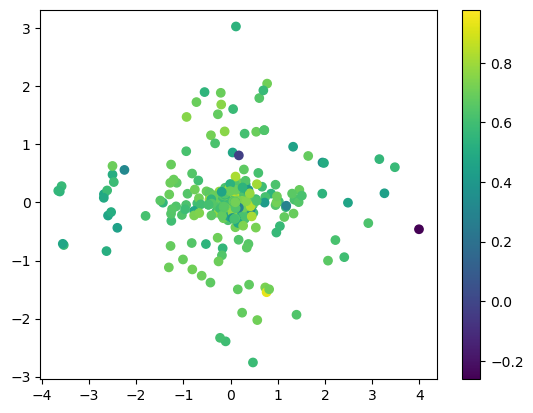

In [460]:
# PCA decomposition on absolute metrics
model = PCA(n_components=2)
pca = model.fit_transform(absolute_np)
plt.scatter(pca[:, 0], pca[:, 1], c=homa_df["outer_circuit"], alpha=1)
plt.colorbar()

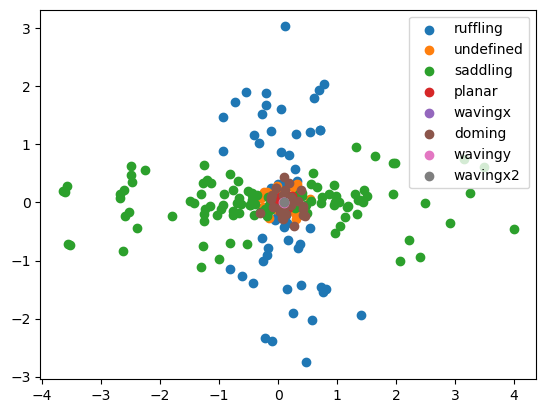

In [461]:
# PCA color by dominant mode
pca_df = pd.DataFrame(pca, index=absolute_np.index)
for mode in dominant_mode["dominant"].unique():
    ids = dominant_mode[dominant_mode["dominant"] == mode].index
    plt.scatter(pca_df.loc[ids, 0], pca_df.loc[ids, 1], label=mode)
plt.legend()

In [ ]:
significance = pd.DataFrame(data=model.components_, columns=absolute_np.columns)
significance

# Clustering Analysis

choosing clustering algorithm and number of clusters

In [232]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [ ]:
# nrange = np.linspace(0.1, 3, 15)
nrange = range(2, 12)
metrics = [silhouette_score, calinski_harabasz_score]
X = absolute_np.to_numpy()
dfs = []
for _ in range(10):
    scores = []
    for n in nrange:
        model = GaussianMixture(n_components=n)
        labels = model.fit_predict(X)
        ajr = {}
        for score_func in metrics:
            try:
                ajr[score_func.__name__] = score_func(X, labels)
            except ValueError:
                ajr[score_func.__name__] = None
        scores.append(ajr)
    dfs.append(pd.DataFrame(scores, index=nrange))
df = sum(dfs) / 10
for col in df.columns:
    plt.figure()
    plt.plot(df.index, df[col])
    plt.title(col)
    plt.xticks(df.index)

In [ ]:
for mode in dominant_mode["dominant"].unique():
    ids = dominant_mode[dominant_mode["dominant"] == mode].index
    plt.figure()
    scatter_plot(dominant_mode.loc[ids, "total"], homa_df.loc[ids, "outer_circuit"], xname="total out of plane", yname="homa", label=mode, add_fitted_line=True)
    plt.legend()

analyzing cluster contents

In [361]:
def cluster_df(n_clusters, aromaticity_df, column_name):
    model = GaussianMixture(n_components=n_clusters)
    labels = model.fit_predict(X)
    absolute_np["cluster"] = labels
    data = []
    clusters = absolute_np["cluster"].unique() 
    for cl in clusters:
        ids = absolute_np[absolute_np["cluster"] == cl].index
        sample = aromaticity_df.loc[ids, column_name]
        pvalue = p_value(sample, aromaticity_df[column_name])
        d = {"mean": sample.mean(), "N": len(sample), "p": pvalue}
        d.update(absolute_np.loc[ids, :].mean(axis=0).to_dict())
        data.append(d)
    df = pd.DataFrame(data, index=clusters)
    return df[df["p"] < 0.05]

In [405]:
prop = "outer_circuit"
print("Population mean:", homa_df["outer_circuit"].mean())
cluster_df(10, homa_df, "outer_circuit")

Population mean: 0.6226415993343458


,mean,N,p,doming,saddling,ruffling,wavingx,wavingy,propellering,doming2,saddling2,ruffling2,wavingx2,propellering2,cluster
8,0.546183,13,0.020528,-0.029717,2.292750,0.131388,0.009327,-0.052579,0.014419,0.035751,0.286583,-0.020584,0.017023,0.013897,8.0
7,0.387425,5,0.000010,-0.046841,-3.237749,-0.127024,-0.066143,-0.097380,-0.003661,0.013323,-0.376749,-0.015379,0.010878,-0.004283,7.0
